In [1]:
import logging
import tensorflow as tf


GPU_FROM = 3
GPU_TO = 4  

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs visible:{len(visible_devices)}")
tf.config.set_visible_devices(visible_devices[GPU_FROM:GPU_TO],'GPU')

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs to be used: {len(visible_devices)}")

2023-02-21 17:49:45.135062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 17:49:45.277421: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-21 17:49:45.312998: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-21 17:49:45.958556: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:

from segmentation.model import SpaceSegmentationTransformer
from segmentation.model import LossWithVoids
GLOBAL_MAX_SEQ_LEN = 5
data = tf.random.stateless_binomial(shape=(10000, GLOBAL_MAX_SEQ_LEN), counts=1, probs=0.65, seed=[1997,1997])+1
train_frac = int(data.shape[0]*3/4)

train_ds, val_ds = tf.data.Dataset.from_tensor_slices(data[:train_frac]), tf.data.Dataset.from_tensor_slices(data[train_frac:])

def mapper(y):
    x = tf.strings.as_string(y+3)
    x = tf.strings.reduce_join(x, axis=-1)
    return tf.strings.regex_replace(x, "(45)", r"\1 ")

train_ds = train_ds.map(mapper)
val_ds = val_ds.map(mapper)

for f in train_ds.take(5):
    print(f)

tf.Tensor(b'55555', shape=(), dtype=string)
tf.Tensor(b'445 45 ', shape=(), dtype=string)
tf.Tensor(b'55554', shape=(), dtype=string)
tf.Tensor(b'4445 5', shape=(), dtype=string)
tf.Tensor(b'5445 4', shape=(), dtype=string)


2023-02-21 17:49:47.248454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 17:49:47.960041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22296 MB memory:  -> device: 3, name: GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


In [3]:
def generate_labels(text):
    max_chars = GLOBAL_MAX_SEQ_LEN
    last_char = tf.strings.substr(text, max_chars, max_chars+1)
    text = tf.strings.substr(text,0, max_chars)
    text = tf.strings.lower(text)
    split_on_whitespace = tf.strings.strip(tf.strings.split(text))
    encoder_in = tf.strings.reduce_join(split_on_whitespace, axis=-1)
    
    space_indices = tf.math.cumsum(tf.strings.length(split_on_whitespace)) - 1 # subtract 1 to index from 0
    seq_len = space_indices[-1] + 1
    if not tf.strings.regex_full_match(last_char, " "):
        space_indices = space_indices[:-1]
    encoder_out = tf.ones((max_chars,))
    encoder_out = tf.concat([
        tf.ones((seq_len,)),
        tf.zeros((max_chars - seq_len,))
    ], axis=-1)
    encoder_out = tf.tensor_scatter_nd_update(
        encoder_out, 
        space_indices[...,tf.newaxis], # Expand dims to create a 'list' of indices
        tf.ones_like(space_indices, dtype=encoder_out.dtype)*2) 
    
    return (encoder_in, None), tf.cast(encoder_out, "float16")

train_ds = train_ds.map(generate_labels)
val_ds = val_ds.map(generate_labels)

In [4]:

for f in train_ds.take(4):
    print(f)

((<tf.Tensor: shape=(), dtype=string, numpy=b'55555'>, None), <tf.Tensor: shape=(5,), dtype=float16, numpy=array([1., 1., 1., 1., 1.], dtype=float16)>)
((<tf.Tensor: shape=(), dtype=string, numpy=b'4454'>, None), <tf.Tensor: shape=(5,), dtype=float16, numpy=array([1., 1., 2., 1., 0.], dtype=float16)>)
((<tf.Tensor: shape=(), dtype=string, numpy=b'55554'>, None), <tf.Tensor: shape=(5,), dtype=float16, numpy=array([1., 1., 1., 1., 1.], dtype=float16)>)
((<tf.Tensor: shape=(), dtype=string, numpy=b'4445'>, None), <tf.Tensor: shape=(5,), dtype=float16, numpy=array([1., 1., 1., 1., 0.], dtype=float16)>)


In [5]:
tokenizer = tf.keras.layers.TextVectorization(
    output_sequence_length=GLOBAL_MAX_SEQ_LEN,
    standardize="lower_and_strip_punctuation",
    split="character",
    output_mode="int",
)

tokenizer.adapt(train_ds.take(10).map(lambda x,y: x[0]))
tokenizer.get_vocabulary()

['', '[UNK]', '5', '4']

In [6]:
tokenizer("44444455555")

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 3, 3, 3, 3])>

In [7]:
model = SpaceSegmentationTransformer(
    num_layers=2,
    d_model=512,
    num_attention_heads=3,
    seq_len=GLOBAL_MAX_SEQ_LEN,
    dff=1028,
    input_tokenizer=tokenizer,
    dropout_rate=0.1,
    num_classes = 3
)

In [8]:
from segmentation.metrics import SparseAccuracyWithIgnore
from segmentation.metrics import SparsePrecision
from segmentation.metrics import SparseRecall
from segmentation.metrics import SparseF1

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0), # Why can I not ignore class 0?
    metrics=[
        SparseAccuracyWithIgnore(ignore_token=0),
        SparsePrecision(class_id=2, name="space_precision"),
        SparseRecall(class_id=2, name="space_recall"),
        SparseF1(class_id=2, name="space_f1"),
        SparsePrecision(class_id=1, name="char_precision"),
        SparseRecall(class_id=1, name="char_recall"),
        SparseF1(class_id=1, name="char_f1"),
    ]
)

In [9]:
train_ds = train_ds.shuffle(100).batch(8)
val_ds = val_ds.batch(8)

model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
  7/938 [..............................] - ETA: 21s - loss: 2.6217 - sparse_categorical_accuracy: 0.6371 - space_precision: 0.0435 - space_recall: 0.0625 - space_f1: 0.0513 - char_precision: 0.7464 - char_recall: 0.7222 - char_f1: 0.7341        

2023-02-21 17:49:54.642254: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


938/938 [==============================] - 30s 28ms/step - loss: 0.4107 - sparse_categorical_accuracy: 0.8662 - space_precision: 0.1000 - space_recall: 0.0016 - space_f1: 0.0032 - char_precision: 0.7588 - char_recall: 0.9974 - char_f1: 0.8619 - val_loss: 0.3830 - val_sparse_categorical_accuracy: 0.8677 - val_space_precision: 0.0000e+00 - val_space_recall: 0.0000e+00 - val_space_f1: nan - val_char_precision: 0.7588 - val_char_recall: 1.0000 - val_char_f1: 0.8629
Epoch 2/10
938/938 [==============================] - 25s 26ms/step - loss: 0.3781 - sparse_categorical_accuracy: 0.8682 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.7588 - char_recall: 0.9999 - char_f1: 0.8629 - val_loss: 0.3734 - val_sparse_categorical_accuracy: 0.8677 - val_space_precision: 0.0000e+00 - val_space_recall: 0.0000e+00 - val_space_f1: nan - val_char_precision: 0.7588 - val_char_recall: 1.0000 - val_char_f1: 0.8629
Epoch 3/10
938/938 [==============================] 

In [10]:
model.evaluate(val_ds)

313/313 [==============================] - 4s 13ms/step - loss: 0.3072 - sparse_categorical_accuracy: 0.8677 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.7588 - char_recall: 1.0000 - char_f1: 0.8629


[0.3071914613246918,
 0.8677156567573547,
 0.0,
 0.0,
 nan,
 0.7588000297546387,
 1.0,
 0.8628610372543335]

In [11]:
test_inputs = [("45455", "45444", "55555"),(None,None, None)]
preds = model(test_inputs)
truth = tf.ragged.constant([[1,2,1,2,1], [1,2,1,1,1], [1,1,1,1,1]])
char_conditional = (truth == 1).to_tensor(False, shape=(truth.shape[0],GLOBAL_MAX_SEQ_LEN))
space_conditional = (truth == 2).to_tensor(False, shape=(truth.shape[0],GLOBAL_MAX_SEQ_LEN))

In [12]:
preds, tf.argmax(preds, axis=-1)

(<tf.Tensor: shape=(3, 5, 3), dtype=float32, numpy=
 array([[[5.1103105e-10, 9.8338890e-01, 1.6611146e-02],
         [2.4217973e-06, 7.6779425e-01, 2.3220339e-01],
         [5.1103105e-10, 9.8338890e-01, 1.6611146e-02],
         [2.4217973e-06, 7.6779425e-01, 2.3220339e-01],
         [2.4217973e-06, 7.6779425e-01, 2.3220339e-01]],
 
        [[5.1470755e-10, 9.8339140e-01, 1.6608607e-02],
         [2.4220174e-06, 7.6779592e-01, 2.3220167e-01],
         [5.1470755e-10, 9.8339140e-01, 1.6608607e-02],
         [5.1470755e-10, 9.8339140e-01, 1.6608607e-02],
         [5.1470755e-10, 9.8339140e-01, 1.6608607e-02]],
 
        [[5.4294286e-10, 9.8329329e-01, 1.6706685e-02],
         [5.4294286e-10, 9.8329329e-01, 1.6706685e-02],
         [5.4294286e-10, 9.8329329e-01, 1.6706685e-02],
         [5.4294286e-10, 9.8329329e-01, 1.6706685e-02],
         [5.4294286e-10, 9.8329329e-01, 1.6706685e-02]]], dtype=float32)>,
 <tf.Tensor: shape=(3, 5), dtype=int64, numpy=
 array([[1, 1, 1, 1, 1],
        [1,

Text(0.5, 0.98, 'Probabilities of space/char conditional on character input')

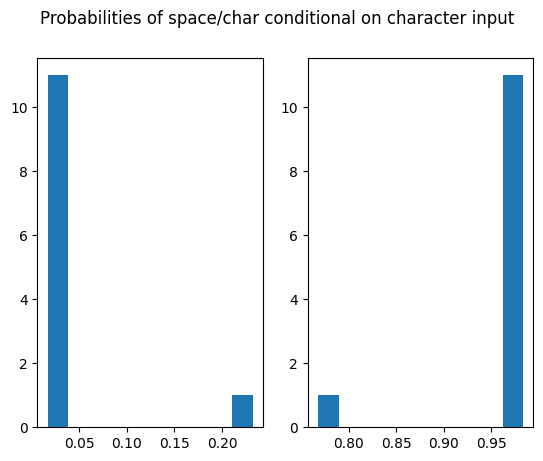

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2)
prob_of_space = preds[char_conditional][...,2]
prob_of_char = preds[char_conditional][...,1]
axs[0].hist(prob_of_space)
# axs[0].set_xlim(0,1)
axs[1].hist(prob_of_char)
# axs[1].set_xlim(0,1)
fig.suptitle("Probabilities of space/char conditional on character input")

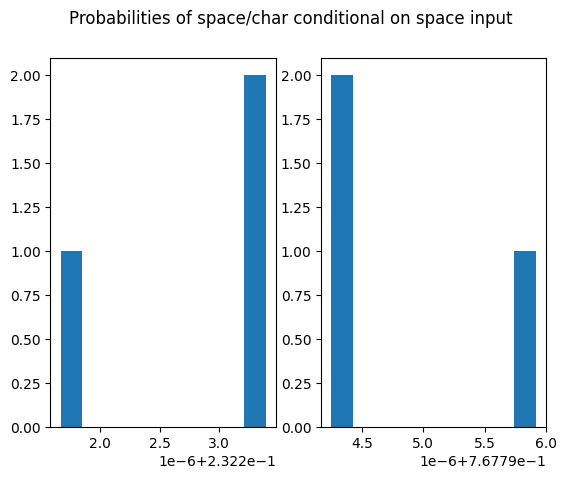

In [14]:
fig, axs = plt.subplots(1,2)
prob_of_space = preds[space_conditional][...,2]
prob_of_char = preds[space_conditional][...,1]
axs[0].hist(prob_of_space)
# axs[0].set_xlim(0,1)
axs[1].hist(prob_of_char)
# axs[1].set_xlim(0,1)
fig.suptitle("Probabilities of space/char conditional on space input")

fig.show()

In [15]:
list(prob_of_char.numpy()), prob_of_space

([0.76779425, 0.76779425, 0.7677959],
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.2322034 , 0.2322034 , 0.23220167], dtype=float32)>)

In [16]:
[len(x) for x in test_inputs[0]], preds._keras_mask.numpy().sum(axis=1)

([5, 5, 5], array([5, 5, 5]))

: 